In [1]:


!gdown --id 1EdqTkztvFjVRu0tgplODmyG9dXwoyX1b
!gdown --id 1WE4Jb_orPxExM7vb8PtL_s3OUWoMW8Ux
! unzip train_hq.zip
! unzip train_masks.zip



Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train_masks/0789bed99cb8_09_mask.gif  
 extracting: train_masks/0789bed99cb8_10_mask.gif  
 extracting: train_masks/0789bed99cb8_11_mask.gif  
 extracting: train_masks/0789bed99cb8_12_mask.gif  
  inflating: train_masks/0789bed99cb8_13_mask.gif  
  inflating: train_masks/0789bed99cb8_14_mask.gif  
  inflating: train_masks/0789bed99cb8_15_mask.gif  
  inflating: train_masks/0789bed99cb8_16_mask.gif  
 extracting: train_masks/0795e132d090_01_mask.gif  
 extracting: train_masks/0795e132d090_02_mask.gif  
 extracting: train_masks/0795e132d090_03_mask.gif  
 extracting: train_masks/0795e132d090_04_mask.gif  
 extracting: train_masks/0795e132d090_05_mask.gif  
 extracting: train_masks/0795e132d090_06_mask.gif  
 extracting: train_masks/0795e132d090_07_mask.gif  
 extracting: train_masks/0795e132d090_08_mask.gif  
 extracting: train_masks/0795e132d090_09_mask.gif  
 extracting: train_masks/0795e132d090_10_mask.gi

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import os
import skimage
from skimage import io
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch.nn import Conv2d as Conv2D
from torch.nn import Upsample
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, utils
from skimage.color.colorconv import rgb2gray

In [3]:
### Target metric ###
def calc_iou(
    prediction: np.array,
    ground_truth: np.array
    ) -> np.array:
    """
    Function for computing IoU metrics.

    Args:
        prediction: batch of binarized predicted masks (either 0 or 1)
        ground_truth: batch of binary GT masks (either 0 or 1)
    Returns:
        calculated iou: np.array
    """
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [4]:
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma   
)

In [5]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=16):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=8, out_channels=out_channels, kernel_size=1
        )
        self.conv_last = nn.Conv2d(features, 8, kernel_size = 3, padding=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)

        #print(enc4.size(), dec4.size())

        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        dec1 = self.conv_last(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [6]:
class SegmentationDataset(Dataset):
    def __init__(
        self,
        root_dir_img,
        root_dir_mask,
        transform
        ):
        super(SegmentationDataset).__init__()
        self.root_dir_img = root_dir_img
        self.root_dir_mask = root_dir_mask
        
        self.files_img = sorted(os.listdir(self.root_dir_img))
        self.files_mask = sorted(os.listdir(self.root_dir_mask))
      
        self.aug = transform
        self.to_tensor = transforms.ToTensor() 
        self.final_transform = transforms.Compose([transforms.ToTensor(),])

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir_img,
                                self.files_img[idx])
        mask_name = os.path.join(self.root_dir_mask,
                                self.files_mask[idx])
      
        img = cv2.imread(img_name)
        mask_ = cv2.imread(mask_name, 0) # if argument is zero, than picture is greyscale one-channel
        
        if self.aug != None:
            augmented =  self.aug(image=img, mask=mask_)

            return (self.final_transform(augmented['image']), 
                    self.to_tensor(augmented['mask']))
        
        return self.final_transform(img), self.to_tensor(mask_)

    def __len__(self):
        return len(self.files_img)

In [7]:
aug = Compose([
    VerticalFlip(p=0.4),
    HorizontalFlip(p=0.4),              
    RandomRotate90(p=0.4),
    OneOf([
        ElasticTransform(
            p=0.4,
            alpha=120,
            sigma=120 * 0.05,
            alpha_affine=120 * 0.03
        ),
        GridDistortion(p=0.5) ], p=0.8),
    CLAHE(p=0.8),
    RandomBrightnessContrast(p=0.5),    
    RandomGamma(p=0.5)])

In [8]:
files_hq = sorted(['train_hq/'+train_hq
    for train_hq in os.listdir('train_hq')
])
files_masks = sorted(['train_masks/'+train_masks
    for train_masks in os.listdir('train_masks')
])

In [9]:


class UtilityClass(torch.utils.data.Dataset):
    def __init__(self, files_hq: list, files_masks: list):
        """Initializes DogsCatsDataset with passed list of files.
        Args:
            files: list of files,
            labels: list of labels.
        """
        self.files_hq = files_hq
        self.files_masks = files_masks

        self.to_tensor = transforms.ToTensor() 
        

    def __getitem__(self, idx: int):
        """Returns the object by given index.
        Args:
            idx - index of the file.
        Returns:
            processed image.
        """

        file = self.files_hq[idx]
        image_1 = cv2.imread(file)
        image_1 = cv2.resize(image_1, (512, 512))

        labels = self.files_masks[idx]
        cap = cv2.VideoCapture(labels)
        ret, image_2 = cap.read()
        image_2 = cv2.resize(image_2, (512, 512))
        
        return self.to_tensor(image_1), self.to_tensor(image_2)
        # return image_1, image_2
        
    def __len__(self):
        """Returns length of files containing in dataset."""
        
        return len(self.files_hq)

data_train, data_val, label_train, label_val = train_test_split(files_hq[:600], files_masks[:600], test_size=0.2)
train_dataset = UtilityClass(data_train, label_train)
val_dataset = UtilityClass(data_val, label_val)
train_loader = DataLoader(train_dataset, batch_size=1,shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1)
train_features, train_labels = next(iter(train_loader))



In [10]:
model = UNet(3,3)
model.cuda()

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, tra

In [11]:
criterion = nn.BCELoss()

train_losses = []
val_losses = []

train_metrics = []
val_metrics = []

hist = {"train_loss": [],
        "train_iou": [],
        "val_loss": [],
        "val_iou": []}

In [12]:
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr)
num_epochs = 8

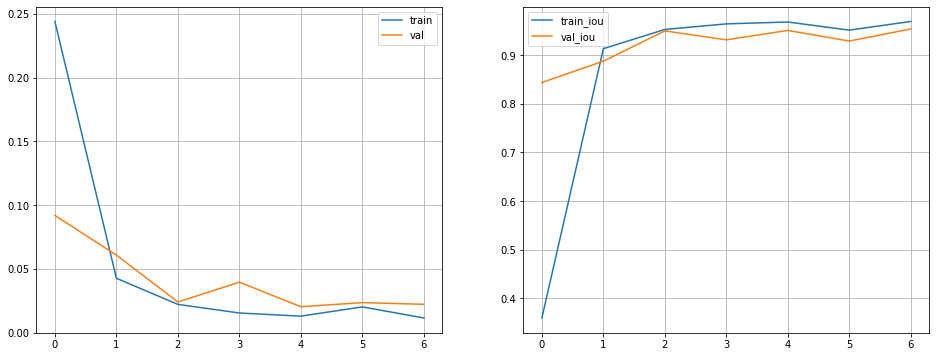

In [13]:
for i in range(num_epochs):
    
    if i>0:
         #print("Epoch %d/%d\t Loss mean: %f\t IoU mean: %f"% \
         #      (i, num_epochs, epoch_loss, epoch_iou))
         #print("Epoch %d/%d\t Val Loss mean: %f\t Val IoU mean: %f"% \
         #      (i, num_epochs, val_loss, val_iou))
    
         plt.figure(figsize=(16, 6))
         plt.subplot(121)
         plt.plot(hist['train_loss'], label='train')
         plt.plot(hist['val_loss'], label='val')
         plt.legend()
         plt.grid()
        
         plt.subplot(122)
         plt.plot(hist['train_iou'], label='train_iou')
         plt.plot(hist['val_iou'], label='val_iou')
         plt.legend()
         plt.grid()
         plt.show()

    epoch_losses = []
    epoch_ious = []
    val_losses = []
    val_ious = []
    
    model.train()
    for k, (img, mask) in enumerate(train_loader):  
        optimizer.zero_grad()
        y_pred = model(img.cuda())
        # print(y_pred.shape, mask.shape)
        loss = criterion(y_pred.cuda(), mask.cuda())
        
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        iou = calc_iou(y_pred.cpu().detach().numpy()>0.1, 
                                  mask.numpy())
        epoch_ious.append(iou)
        
        
        #if k%5 == 0:
        #    print("Epoch: %d \tLoss: %f"%(i+1, loss.item()))
    
    epoch_loss = np.mean(np.array(epoch_losses))
    epoch_iou = np.mean(np.array(epoch_ious))
    hist['train_iou'].append(epoch_iou)
    hist['train_loss'].append(epoch_loss)
    with torch.no_grad():
        model.eval()
        for k, (img, mask) in enumerate(val_loader):
            y_pred = model(img.cuda())
            loss = criterion(y_pred, mask.cuda())
            iou = calc_iou(y_pred.cpu().detach().numpy()>0.15, 
                                  mask.numpy())
            val_losses.append(loss.item())
            val_ious.append(iou)
            
            
            
    val_loss = np.mean(np.array(val_losses))
    val_iou = np.mean(np.array(val_ious))
    hist['val_loss'].append(val_loss)
    hist['val_iou'].append(val_iou)
    if i < (num_epochs - 1):
        clear_output()

In [17]:


torch.save(model.state_dict(), "weights0.h5f")



In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:


THRESH = 0.1

with torch.no_grad():
    model.eval()
    val_ious = []
    for k, (img, mask) in enumerate(val_loader):
        v_pred = model(img.cuda())
        loss = criterion(v_pred.float(), mask.cuda().float())
        
        iou = calc_iou(v_pred.cpu().detach().numpy()>THRESH, 
                                  mask.numpy())
        val_ious.append(iou)
            
    
    val_iou = np.mean(np.array(val_ious))
    
    print("IoU on Val set: %.3f" % val_iou)



IoU on Val set: 0.929
